Since Rapidae uses the new version of Keras 3, this allows the use of different backends. 
We can select among the 3 available backends (Tensorflow, Pytorch and Jax) by modifying the environment variable "KERAS_BACKEND".
In the next cell we can define it.

In [1]:
import os

os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import sys

notebook_dir = os.path.abspath('')
sys.path.append(os.path.join(notebook_dir, '..'))

import numpy as np

from sklearn.metrics import accuracy_score
from keras import utils
from rapidae.data.datasets import load_MNIST
from rapidae.data.utils import evaluate, display_diff, add_noise
from rapidae.models.ae.ae_model import AE
from rapidae.models.base.default_architectures import SparseEncoder, SparseDecoder
from rapidae.pipelines.training import TrainingPipeline

Download and preprocess the dataset. In this example, the selected dataset is the well-known MNIST composed of handwritten number images.

The "persistant" parameter of the load_MNIST() serves as a flag to determine if we want the dataset to be cached in the datasets folder.

In [3]:
# Load MNIST dataset
x_train, y_train, x_test, y_test = load_MNIST(persistant=True)

x_train = x_train.reshape(x_train.shape[0], -1) / 255
x_test = x_test.reshape(x_test.shape[0], -1) / 255

# Obtain number of clasess
n_classes = len(set(y_train))

# Convert labels to categorical
y_train = utils.to_categorical(y_train, n_classes)
y_test = utils.to_categorical(y_test, n_classes)

2023-12-27 14:32:46 [INFO]: train-images-idx3-ubyte.gz already exists.
2023-12-27 14:32:46 [INFO]: train-labels-idx1-ubyte.gz already exists.
2023-12-27 14:32:46 [INFO]: t10k-images-idx3-ubyte.gz already exists.
2023-12-27 14:32:46 [INFO]: t10k-labels-idx1-ubyte.gz already exists.


In [4]:
# Model creation
model = AE(input_dim=x_train.shape[1], 
            latent_dim=32, encoder=SparseEncoder, decoder=SparseDecoder, layers_conf=[128, 64])

In [5]:
pipe = TrainingPipeline(name='training_pipeline',
                        model=model, num_epochs=10, learning_rate=0.01)

trained_model = pipe(x=x_train, y=y_train)

2023-12-27 14:32:47 [INFO]: +++ training_pipeline +++
2023-12-27 14:32:47 [INFO]: Creating folder in ../output_dir/training_pipeline_2023-12-27_14-32-47
/home/lucaspc/venvs/keras_core/lib/python3.11/site-packages/keras/src/layers/layer.py:358: UserWarning: `build()` was called on layer 'encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/10

Epoch 1: loss improved from inf to 0.06506, saving model to ../output_dir/training_pipeline_2023-12-27_14-32-47/model.weights.h5
469/469 - 2s - 4ms/step - loss: 0.0651
Epoch 2/10

Epoch 2: loss improved from 0.06506 to 0.04626, saving model to ../output_dir/training_pipeline_2023-12-27_14-32-47/model.weights.h5
469/469 - 2s - 3ms/step - loss: 0.0463
Epoch 3/10

Epoch 3: loss improved from 0.04626 to 0.03593, saving model to ../output_dir/training_pipeline_2023-12-27_14-32-47/model.weights.h5
469/469 - 2s - 3ms/step - loss: 0.0359
Epoch 4/10

Epoch 4: loss improved from 0.03593 to 0.03036, saving model to ../output_dir/training_pipeline_2023-12-27_14-32-47/model.weights.h5
469/469 - 2s - 3ms/step - loss: 0.0304
Epoch 5/10

Epoch 5: loss improved from 0.03036 to 0.02702, saving model to ../output_dir/training_pipeline_2023-12-27_14-32-47/model.weights.h5
469/469 - 2s - 3ms/step - loss: 0.0270
Epoch 6/10

Epoch 6: loss improved from 0.02702 to 0.02452, saving model to ../outpu

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


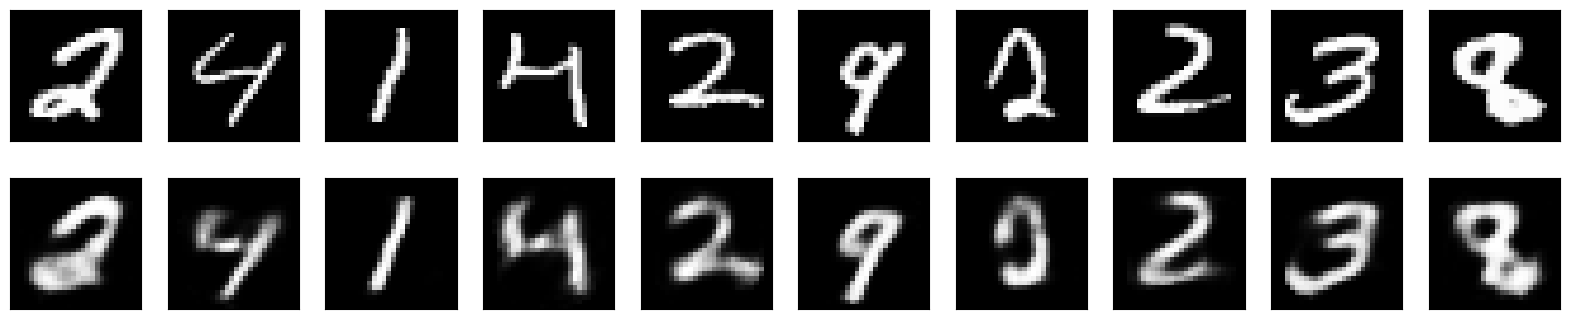

In [6]:
y_hat = trained_model.predict(x_test)

display_diff(x_test, y_hat['recon'])